<img src="https://media.licdn.com/dms/image/C5612AQG0Gilk9mJpxw/article-cover_image-shrink_720_1280/0/1621963349834?e=2147483647&v=beta&t=S-3_jI-4xWu14OSyh7RJg93TQmLc_QWTZAW5Gd_aL8s" width=1600 height=800 />

# Unveiling Customer Churn Patterns: Predictive Insights from Telco Company Dataset

<div style="text-align: justify"> In the realm of modern business dynamics, anticipating customer behaviors is paramount. This project focuses on developing a machine learning model to predict customer churn, a critical concern where customers discontinue engagement with a service. By analyzing real data from a Telco company, this notebook aims to construct a predictive model that can identify potential churners. The process involves preprocessing data, exploring trends, and implementing diverse machine learning techniques to derive insights and build an effective prediction tool. This project equips businesses with the capability to proactively address customer attrition, thereby enhancing customer retention strategies and overall operational efficiency. </div>

## Dataset Information

The Telco customer churn data provides information about an imaginary telecommunications company that offers home phone and internet services to 7,043 customers in California during the third quarter. It indicates whether customers have left, remained, or signed up for services. The dataset includes 21 variables and 7,043 observations, occupying 977.5 KB in size.

Variables include:

- **CustomerId**: Customer ID
- **Gender**: Gender
- **SeniorCitizen**: Whether the customer is a senior citizen (1, 0)
- **Partner**: Whether the customer has a partner (Yes, No)
- **Dependents**: Whether the customer has dependents (Yes, No)
- **tenure**: Number of months the customer has stayed with the company
- **PhoneService**: Whether the customer has phone service (Yes, No)
- **MultipleLines**: Whether the customer has multiple lines (Yes, No, No phone service)
- **InternetService**: The customer's internet service provider (DSL, Fiber optic, No)
- **OnlineSecurity**: Whether the customer has online security (Yes, No, No internet service)
- **OnlineBackup**: Whether the customer has online backup (Yes, No, No internet service)
- **DeviceProtection**: Whether the customer has device protection (Yes, No, No internet service)
- **TechSupport**: Whether the customer has tech support (Yes, No, No internet service)
- **StreamingTV**: Whether the customer has streaming TV (Yes, No, No internet service)
- **StreamingMovies**: Whether the customer has streaming movies (Yes, No, No internet service)
- **Contract**: The customer's contract duration (Month-to-month, One year, Two years)
- **PaperlessBilling**: Whether the customer has paperless billing (Yes, No)
- **PaymentMethod**: The customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- **MonthlyCharges**: The amount billed monthly to the customer
- **TotalCharges**: The total amount billed to the customer
- **Churn**: Whether the customer has churned (Yes or No)

## Imported Libraries

In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import joblib
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

## Defined Functions

In [286]:
def uniqueInfos(df):
    
    dictz = {"FEATURES": df.columns,
             "N_UNIQUE": [df[item].nunique() for item in df.columns],
             "N_NULL": [df[item].isnull().sum() for item in df.columns],
             "ITEMS": [df[item].unique() for item in df.columns],
             "TYPE" : [df[item].dtype for item in df.columns]}
    
    return pd.DataFrame(data = dictz)

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return round(low_limit), round(up_limit)


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

# Base Models
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "min mean max".split()}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)
    
def data_prep(dataframe):
    
    dataframe.replace(" ", np.nan, inplace=True)
    dataframe["TotalCharges"] = dataframe["TotalCharges"].astype("float")

    for column in dataframe.select_dtypes(include=['object']).columns:
        dataframe[column] = dataframe[column].astype('category')
    
    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "Churn" not in col]
    
    
    dataframe.dropna(inplace = True)
    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)
   
    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["Churn"].replace({'Yes': 1, 'No': 0})
    X = df.drop(["Churn"], axis=1)

    return X, y

def voting_classifier(best_models, X, y):
    print("Voting Classifier...")
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]), ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [287]:
file = [file for file in os.listdir(os.getcwd()) if ".csv" in file]
df   = pd.read_csv(os.getcwd() + "/" + file[0])
df_  = df.copy()
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [289]:
df.replace(" ", np.nan, inplace=True)

In [290]:
df["TotalCharges"] = df["TotalCharges"].astype("float")

for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype('category')
    


In [291]:
uniqueInfos(df)

,FEATURES,N_UNIQUE,N_NULL,ITEMS,TYPE
0,customerID,7043,0,"['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', '77...",category
1,gender,2,0,"['Female', 'Male'] Categories (2, object): ['F...",category
2,SeniorCitizen,2,0,"[0, 1]",int64
3,Partner,2,0,"['Yes', 'No'] Categories (2, object): ['No', '...",category
4,Dependents,2,0,"['No', 'Yes'] Categories (2, object): ['No', '...",category
5,tenure,73,0,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",int64
6,PhoneService,2,0,"['No', 'Yes'] Categories (2, object): ['No', '...",category
7,MultipleLines,3,0,"['No phone service', 'No', 'Yes'] Categories (...",category
8,InternetService,3,0,"['DSL', 'Fiber optic', 'No'] Categories (3, ob...",category
9,OnlineSecurity,3,0,"['No', 'Yes', 'No internet service'] Categorie...",category


In [292]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print("")
print("Categorical Columns: ", ", ".join(str(item) for item in cat_cols))
print("Numerical Columns  : ", ", ".join(str(item) for item in num_cols))

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 4
cat_but_car: 0
num_but_cat: 17

Categorical Columns:  gender, SeniorCitizen, Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, Churn
Numerical Columns  :  customerID, tenure, MonthlyCharges, TotalCharges


In [293]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.000,0.162,0.369,0.000,0.000,0.000,0.000,1.000
tenure,7043.000,32.371,24.559,0.000,9.000,29.000,55.000,72.000
MonthlyCharges,7043.000,64.762,30.090,18.250,35.500,70.350,89.850,118.750
TotalCharges,7032.000,2283.300,2266.771,18.800,401.450,1397.475,3794.738,8684.800


No outliers detected!


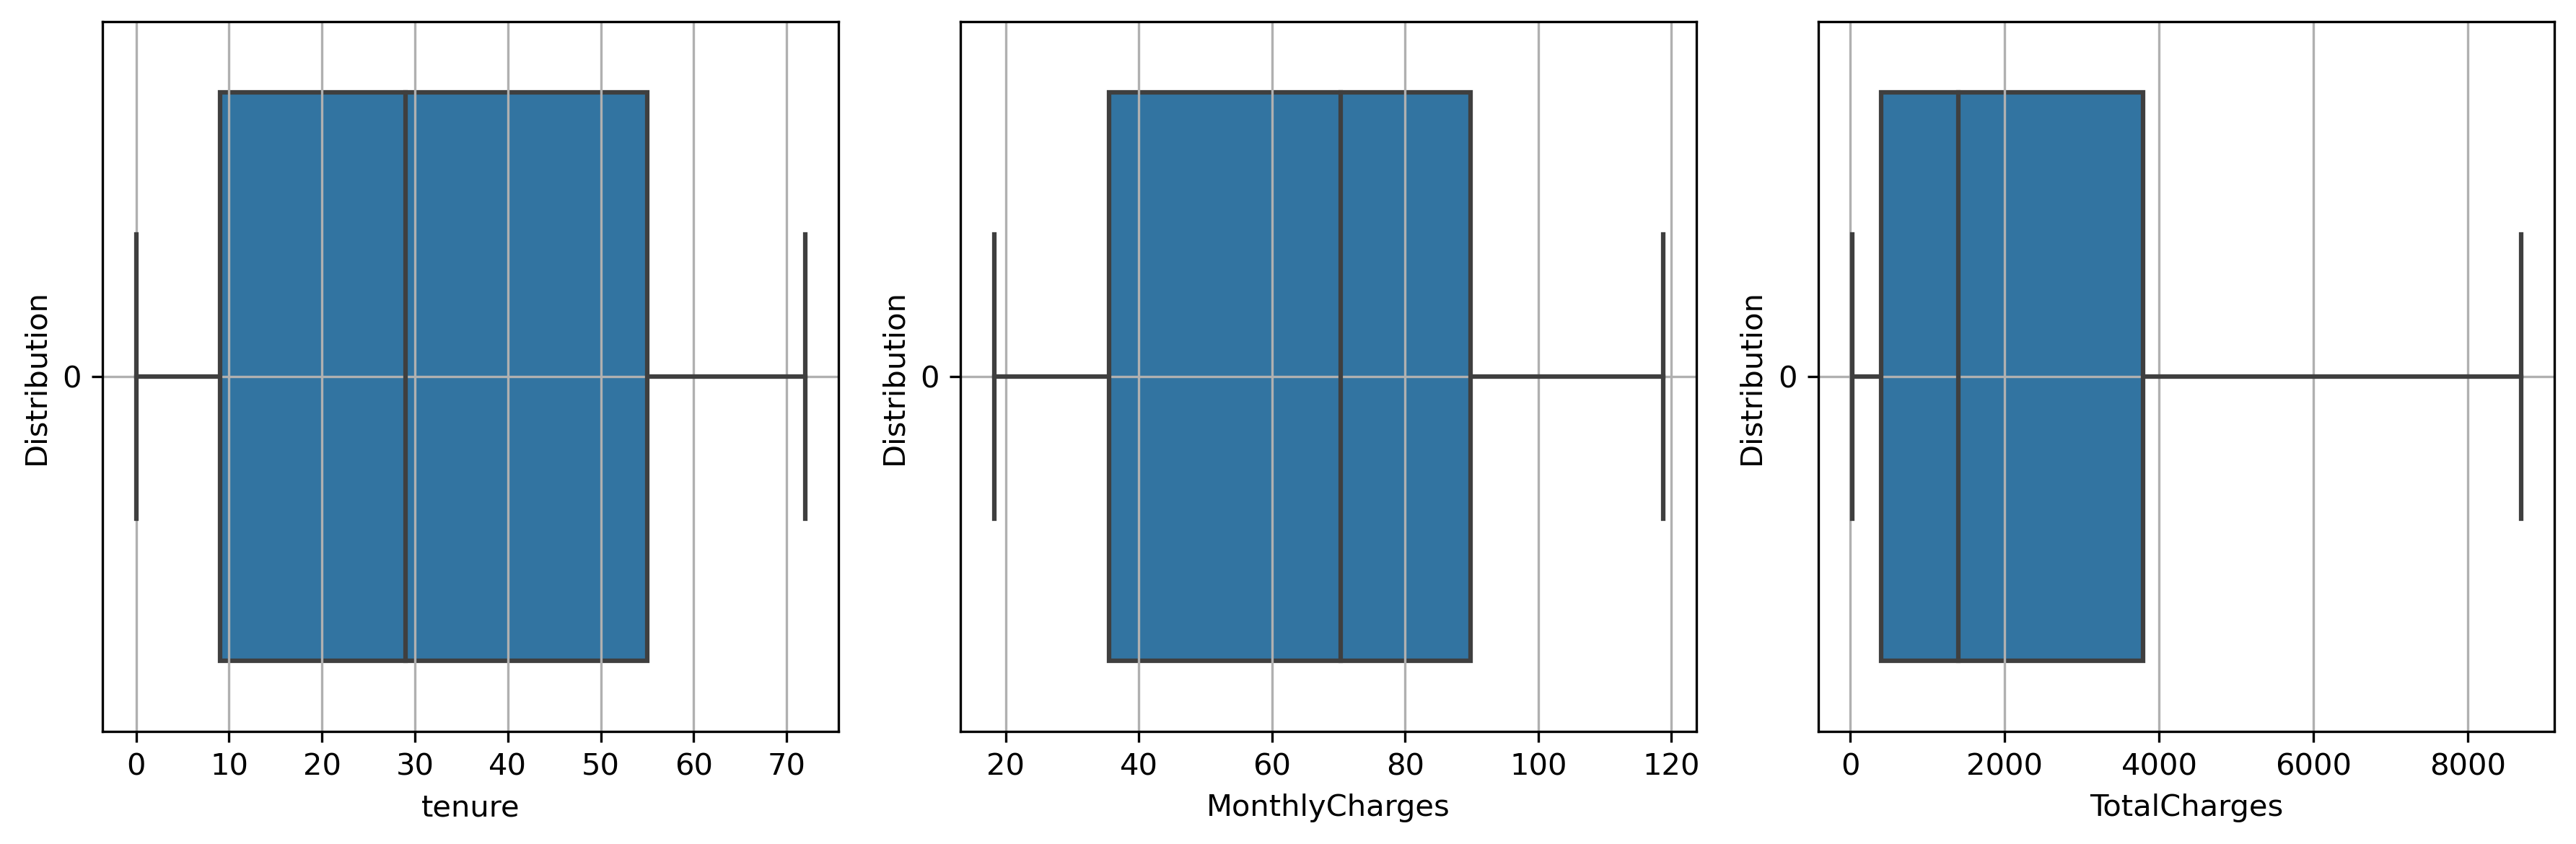

In [294]:
m, n = 1, 3
w = 0

fig, axes = plt.subplots(m, n, figsize = (12, 4), dpi = 300)

for i in range(n):
        
        sns.boxplot(data = df[num_cols[i+1]], 
                    orient = "h",
                    ax = axes[i])
        
        axes[i].grid(True)
        axes[i].set_xlabel(num_cols[i+1])
        axes[i].set_ylabel("Distribution")
        w = w+1
        
plt.tight_layout()
print("No outliers detected!")

In [295]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

        gender  Ratio
Male      3555 50.476
Female    3488 49.524
##########################################


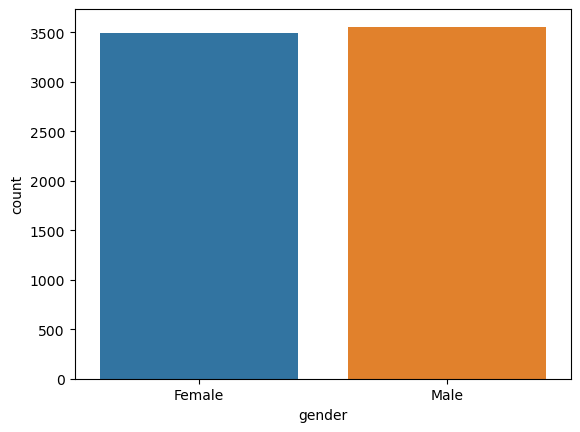

   SeniorCitizen  Ratio
0           5901 83.785
1           1142 16.215
##########################################


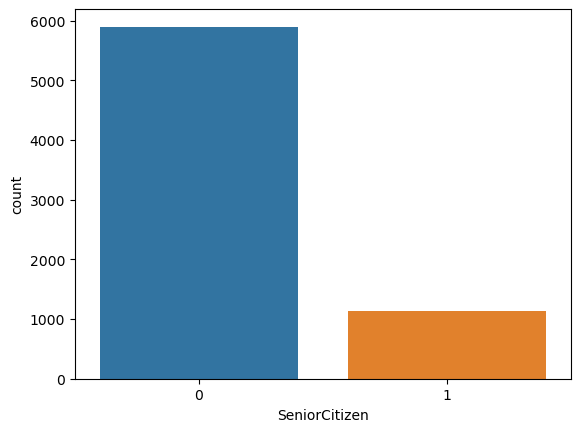

     Partner  Ratio
No      3641 51.697
Yes     3402 48.303
##########################################


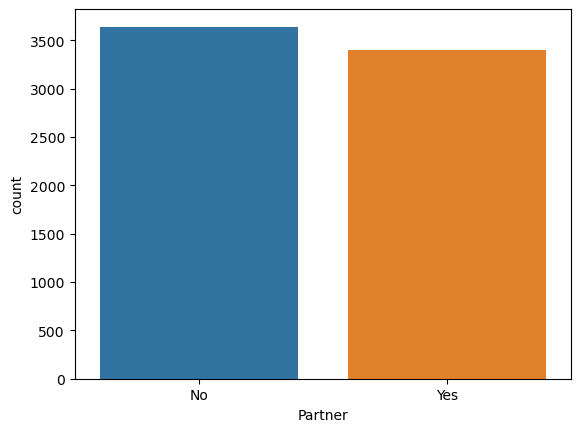

     Dependents  Ratio
No         4933 70.041
Yes        2110 29.959
##########################################


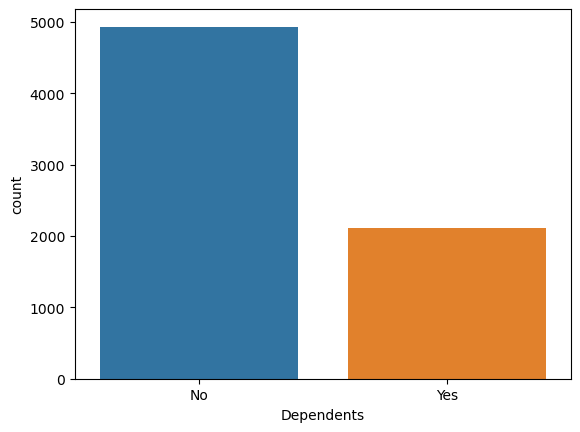

     PhoneService  Ratio
Yes          6361 90.317
No            682  9.683
##########################################


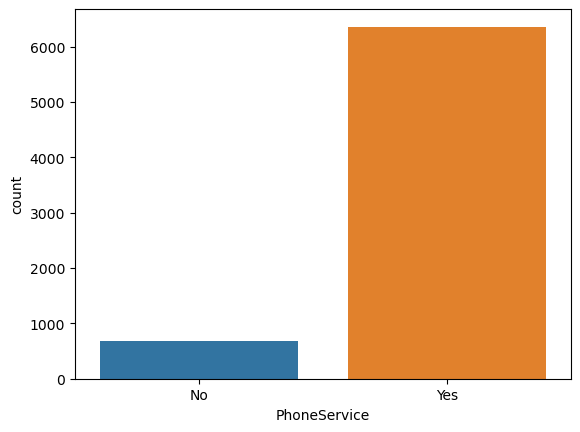

                  MultipleLines  Ratio
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################


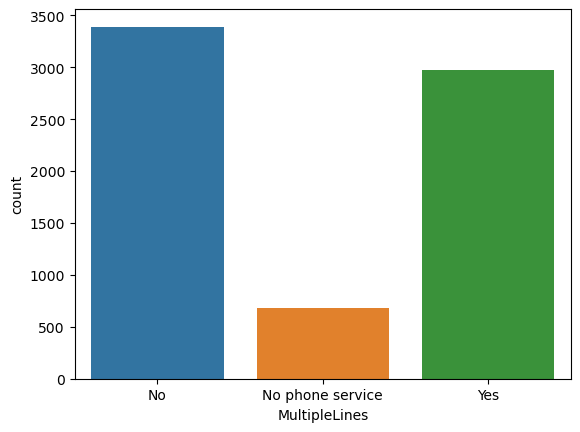

             InternetService  Ratio
Fiber optic             3096 43.959
DSL                     2421 34.375
No                      1526 21.667
##########################################


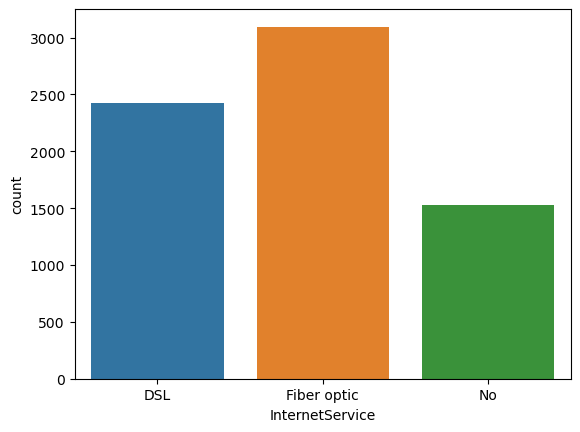

                     OnlineSecurity  Ratio
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667
##########################################


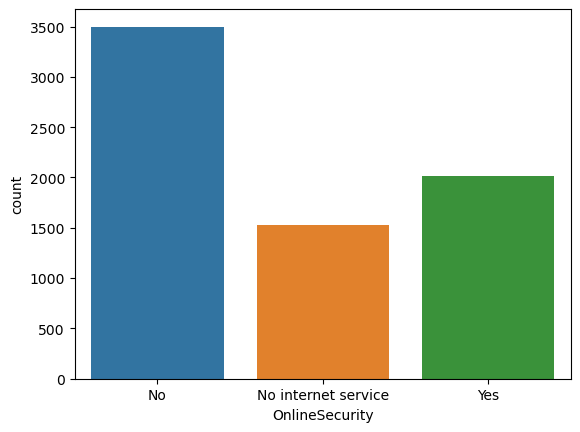

                     OnlineBackup  Ratio
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667
##########################################


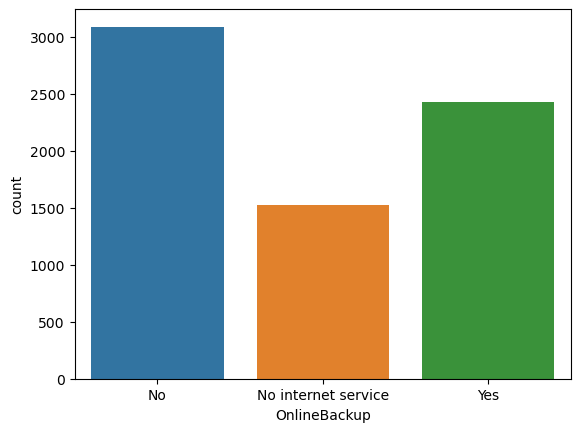

                     DeviceProtection  Ratio
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667
##########################################


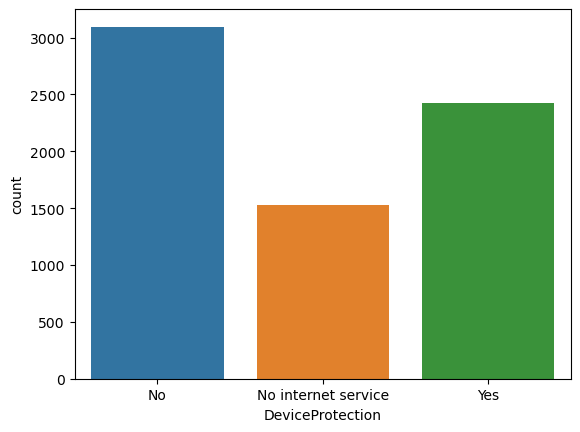

                     TechSupport  Ratio
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667
##########################################


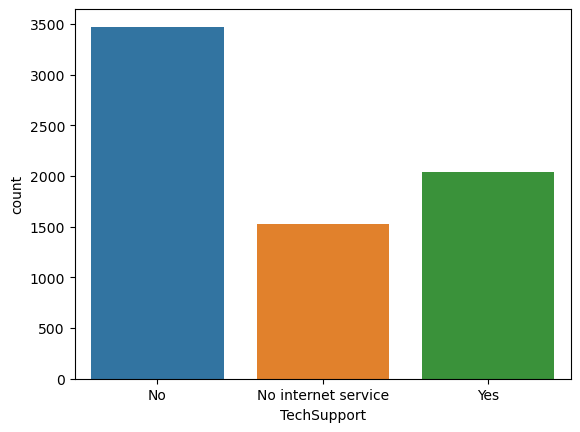

                     StreamingTV  Ratio
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667
##########################################


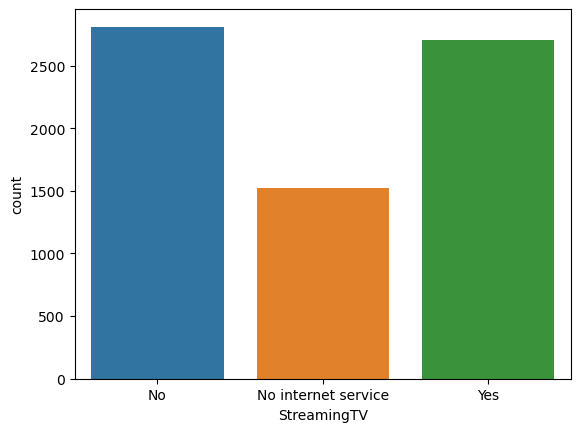

                     StreamingMovies  Ratio
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667
##########################################


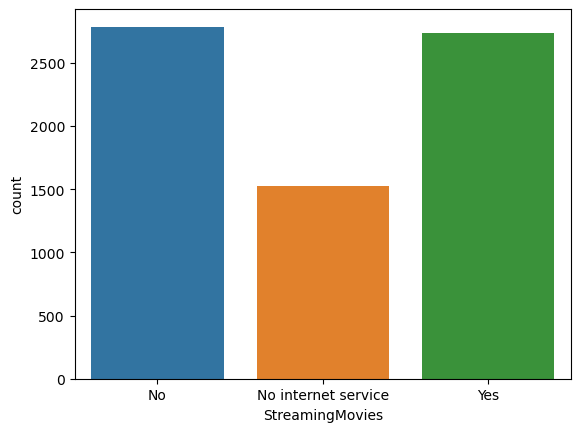

                Contract  Ratio
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914
##########################################


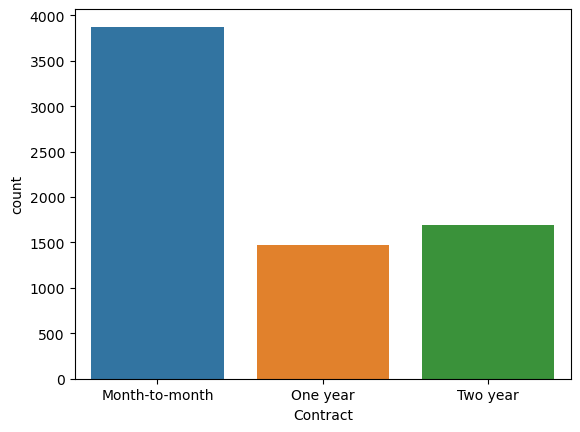

     PaperlessBilling  Ratio
Yes              4171 59.222
No               2872 40.778
##########################################


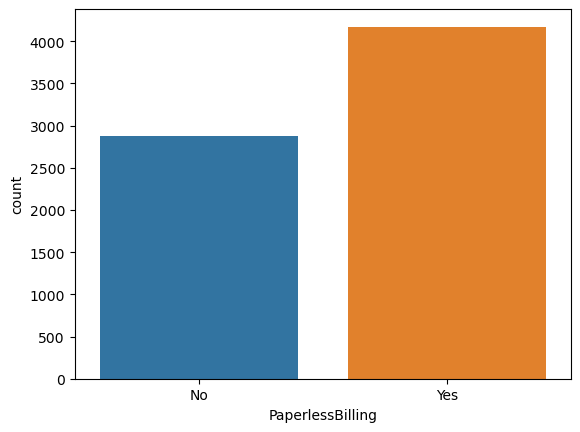

                           PaymentMethod  Ratio
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610
##########################################


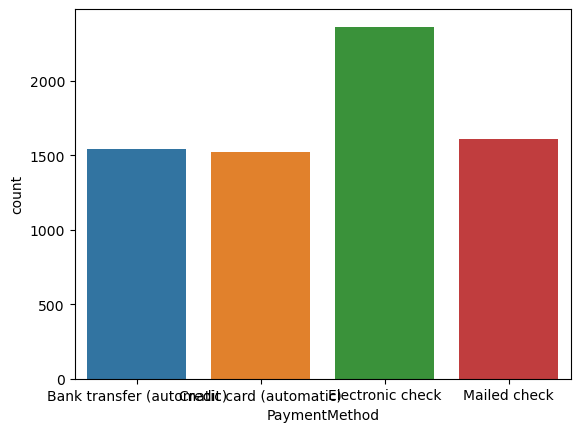

     Churn  Ratio
No    5174 73.463
Yes   1869 26.537
##########################################


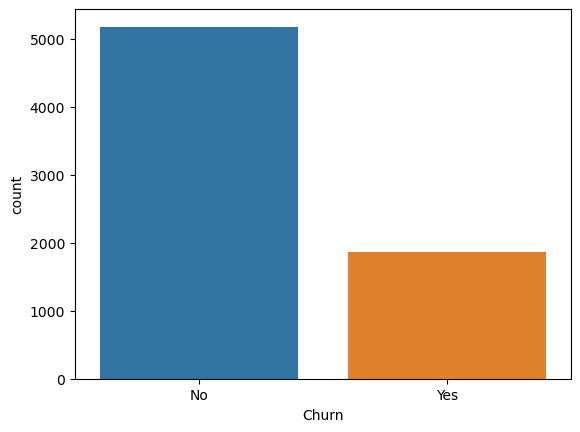

In [296]:
for item in cat_cols:
    cat_summary(df, item, plot = True)

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


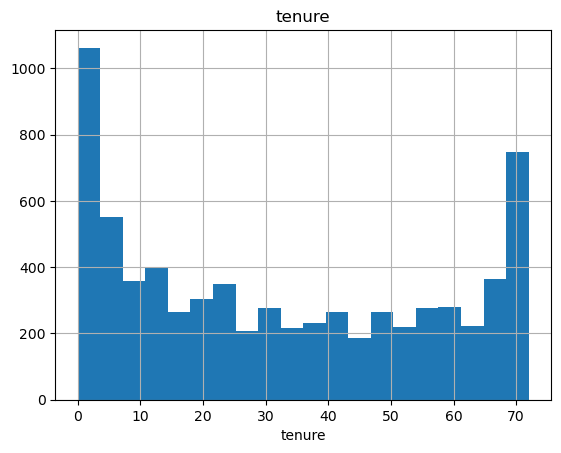

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


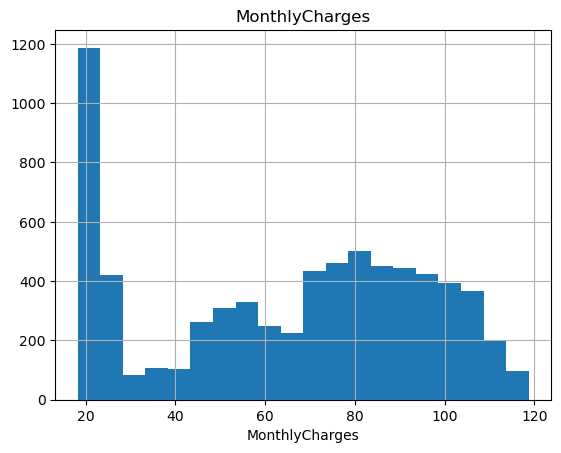

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


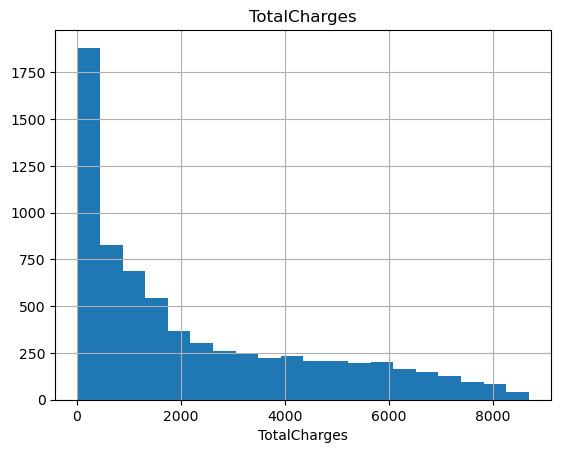

In [297]:
for item in num_cols[1:]:
    num_summary(df, item, plot = True)

In [298]:
for item in num_cols[1:]:
    target_summary_with_num(df, "Churn", item)

      tenure           
         min   mean max
Churn                  
No         0 37.570  72
Yes        1 17.979  72


      MonthlyCharges               
                 min   mean     max
Churn                              
No            18.250 61.265 118.750
Yes           18.850 74.441 118.350


      TotalCharges                  
               min     mean      max
Churn                               
No          18.800 2555.344 8672.450
Yes         18.850 1531.796 8684.800




In [299]:
df = df.dropna().reset_index(drop = True)

In [300]:
uniqueInfos(df)

,FEATURES,N_UNIQUE,N_NULL,ITEMS,TYPE
0,customerID,7032,0,"['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', '77...",category
1,gender,2,0,"['Female', 'Male'] Categories (2, object): ['F...",category
2,SeniorCitizen,2,0,"[0, 1]",int64
3,Partner,2,0,"['Yes', 'No'] Categories (2, object): ['No', '...",category
4,Dependents,2,0,"['No', 'Yes'] Categories (2, object): ['No', '...",category
5,tenure,72,0,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",int64
6,PhoneService,2,0,"['No', 'Yes'] Categories (2, object): ['No', '...",category
7,MultipleLines,3,0,"['No phone service', 'No', 'Yes'] Categories (...",category
8,InternetService,3,0,"['DSL', 'Fiber optic', 'No'] Categories (3, ob...",category
9,OnlineSecurity,3,0,"['No', 'Yes', 'No internet service'] Categorie...",category


In [301]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [302]:
df

,customerID,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,7590-VHVEG,1,29.850,29.850,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,34,56.950,1889.500,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,2,53.850,108.150,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,7795-CFOCW,45,42.300,1840.750,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,9237-HQITU,2,70.700,151.650,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,24,84.800,1990.500,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0
7028,2234-XADUH,72,103.200,7362.900,0,0,1,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,1,0,0,0
7029,4801-JZAZL,11,29.600,346.450,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
7030,8361-LTMKD,4,74.400,306.600,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [304]:
df = df.drop("customerID", axis = 1)

In [305]:
uniqueInfos(df)

,FEATURES,N_UNIQUE,N_NULL,ITEMS,TYPE
0,tenure,72,0,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",int64
1,MonthlyCharges,1584,0,"[29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1,...",float64
2,TotalCharges,6530,0,"[29.85, 1889.5, 108.15, 1840.75, 151.65, 820.5...",float64
3,gender_Male,2,0,"[0, 1]",uint8
4,SeniorCitizen_1,2,0,"[0, 1]",uint8
5,Partner_Yes,2,0,"[1, 0]",uint8
6,Dependents_Yes,2,0,"[0, 1]",uint8
7,PhoneService_Yes,2,0,"[0, 1]",uint8
8,MultipleLines_No phone service,2,0,"[1, 0]",uint8
9,MultipleLines_Yes,2,0,"[0, 1]",uint8


In [306]:
df_ = df.copy()

In [308]:
X_scaled = StandardScaler().fit_transform(df_[num_cols[1:]])

In [310]:
df_[num_cols[1:]] = pd.DataFrame(X_scaled, columns=df_[num_cols[1:]].columns)

In [311]:
df_

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,-1.280,-1.162,-0.994,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0.064,-0.261,-0.174,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,-1.240,-0.364,-0.960,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,0.512,-0.748,-0.195,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,-1.240,0.196,-0.940,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,-0.343,0.665,-0.129,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0
7028,1.613,1.276,2.241,0,0,1,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,1,0,0,0
7029,-0.873,-1.170,-0.855,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
7030,-1.158,0.319,-0.872,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [312]:
y = df["Churn_Yes"]
X = df.drop(["Churn_Yes"], axis=1)

## Hyper-Parameter Optimization

In [314]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

In [315]:
base_models(X, y)

Base Models....
roc_auc: 0.8424 (LR) 


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

roc_auc: 0.7453 (KNN) 
roc_auc: 0.7908 (SVC) 
roc_auc: 0.6573 (CART) 
roc_auc: 0.8235 (RF) 
roc_auc: 0.8415 (Adaboost) 
roc_auc: 0.8447 (GBM) 


C:\Users\cesur\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\cesur\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\cesur\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


roc_auc: 0.8215 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1246, number of negative: 3442
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 4688, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265785 -> initscore=-1.016114
[LightGBM] [Info] Start training from score -1.016114
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1246, number of negative: 3442
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [316]:
best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.7453
roc_auc (After): 0.7824
KNN best params: {'n_neighbors': 33}

########## CART ##########
roc_auc (Before): 0.6592
roc_auc (After): 0.8172
CART best params: {'max_depth': 7, 'min_samples_split': 20}

########## RF ##########
roc_auc (Before): 0.8205
roc_auc (After): 0.8407
RF best params: {'max_depth': 15, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 300}

########## XGBoost ##########


C:\Users\cesur\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\cesur\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\cesur\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


roc_auc (Before): 0.8215


C:\Users\cesur\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\cesur\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\cesur\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\cesur\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\cesur\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_

roc_auc (After): 0.8439
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 200}

########## LightGBM ##########
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1246, number of negative: 3442
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 4688, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265785 -> initscore=-1.016114
[LightGBM] [Info] Start training from score -1.016114
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1246, number of negative: 3442
[LightGBM] [Warning] Auto-choosing row-wise multi-t

In [317]:
voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5163
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 7032, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265785 -> initscore=-1.016114
[LightGBM] [Info] Start training from score -1.016114
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1246, number of negative: 3442
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [318]:
joblib.dump(voting_clf, "voting_clf.pkl")

['voting_clf.pkl']